In [1]:
!pip install pandas pysam scikit-learn git+https://github.com/divkov575/scikit-survival

  Cloning https://github.com/divkov575/scikit-survival to /tmp/pip-req-build-zq3_1pz1
  Running command git clone --filter=blob:none --quiet https://github.com/divkov575/scikit-survival /tmp/pip-req-build-zq3_1pz1
  Resolved https://github.com/divkov575/scikit-survival to commit fa1a0035059e6d4f5983dce4f0b76e3704eca901
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.1.dev1327+gfa1a00350-cp313-cp313-linux_x86_64.whl size=884123 sha256=ee752defb6be079796f3acc490b7b188e733dbb134d477c4735b18f93b376b28
  Stored in directory: /tmp/pip-ephem-wheel-cache-8upaot3o/wheels/8e/a5/bd/185535fda97775c6ed248192340bc74567877eb4557d46f391
Successfully built scikit-survival

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import pathlib
import os
import json
import itertools
import numpy as np

root = pathlib.Path("/data/rbg/shared/datasets/TCGA/")

In [41]:
print(os.listdir(f'{root}'))
print()
print(os.listdir(f'{root}/Pathology'))


# os.listdir(f'{root}/Pathology/trident/features_hoptimus1')
# !-n 5 "{root}/Pathology/trident/features_hoptimus1/TCGA-BH-A0EA-01A-01-MSA.a0826f0d-986a-491b-8c6f-b34f8929f3ee.h5"
# !cat "{root}/Pathology/gdc_manifest.2025-06-30.162706.txt" | head -n 5
# !cat "{root}/Pathology/image_info_table_sample_n10.csv" | head -n 5
# !cat "{root}/Pathology/gdc_sample_sheet.2025-06-30.tsv" | head -n 5
# !cat "{root}/Pathology/image_info_table_v02.csv" | head -n 5
# !cat "{root}/Pathology/image_info_table.csv" | head -n 5

['Genomic', '.DS_Store', 'RNA-Seq', 'etoposide_testis', 'Pathology', 'cohort_BLC.2025-06-30.tsv']

['gdc_manifest.2025-06-30.162706.txt', 'image_info_table_sample_n10.csv', 'trident', 'metadata', 'gdc_sample_sheet.2025-06-30.tsv', 'H-optimus-1_features', 'images', 'image_info_table_v02.csv', 'image_info_table.csv']


In [52]:
ids = pd.read_json("ids/tcga_cohort.json")
clinical_data_raw = pd.read_json("./clinical-tcga-brca.json").set_index("case_id")
clinical_data = clinical_data_raw.loc[ids["case_id"]]

clinical_data['stage'] = ids["stage"]

def add_outcome(elem):
    vital_status = elem['demographic'].get('vital_status')

    if vital_status == 'Dead':
        patient_death = elem['demographic'].get('days_to_death')
        return [1, int(patient_death)]

    elif vital_status == "Alive":
        follow_ups = elem['follow_ups']
        follow_up_days = [
            f.get('days_to_follow_up')
            for f in follow_ups
            if f.get('days_to_follow_up') is not None
        ]
        diagnosis_days = [
            d.get('days_to_last_follow_up')
            for d in elem['diagnoses']
            if d.get('days_to_last_follow_up') is not None
        ]
        all_days = follow_up_days + diagnosis_days
        date_of_last_checkup = max(all_days) if all_days else None

        return [0, int(date_of_last_checkup)]
    else:
        typing.assert_never("vital status not in Alive/Dead")

        


clinical_data["outcome"] = clinical_data.apply(add_outcome, axis=1)



def remove_sparse_features(X, threshold=0.05):
    non_zero_fraction = (X != 0).sum(axis=0) / X.shape[0]
    keep = non_zero_fraction > threshold
    print(clinical_data_filtered.shape)
    print(clinical_data_filtered.columns)
    return X.loc[:, keep]


def remove_perfect_correlations(X):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] == 1)]
    print(clinical_data_filtered.shape)
    return X.drop(columns=to_drop)

# print(clinical_data.shape)
# clinical_data_filtered = remove_sparse_features(clinical_data)
clinical_data_filtered = clinical_data

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in clinical_data_filtered["stage"].to_frame(): 
    clinical_data_filtered[col] = le.fit_transform(clinical_data_filtered[col])
clinical_data_filtered["stage_copy"] = clinical_data_filtered["stage"]

clinical_data_filtered = clinical_data_filtered.reset_index()[["stage", "outcome"]]
print(clinical_data_filtered.shape)
clinical_data_filtered.head()


(131, 2)


,stage,outcome
0,0,"[0, 915]"
1,0,"[0, 3248]"
2,0,"[0, 1179]"
3,0,"[0, 10]"
4,0,"[0, 397]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 9.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 13.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


array([[<Axes: title={'center': '0'}>]], dtype=object)

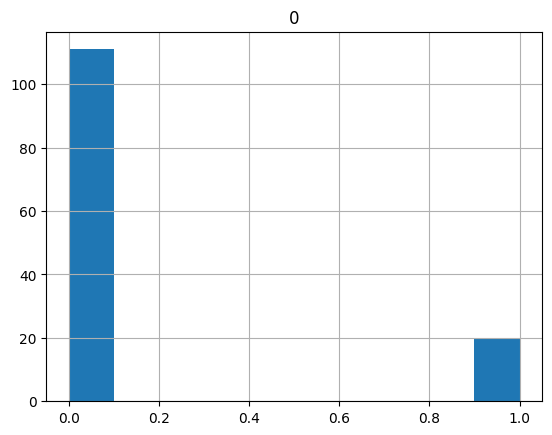

In [55]:
!pip install matplotlib
clinical_data_filtered["outcome"].apply(pd.Series)[0].to_frame().hist()

In [50]:
# resampling test
from sklearn.model_selection import ShuffleSplit, ParameterGrid
from sklearn.linear_model import LinearRegression
from sksurv.linear_model import CoxnetSurvivalAnalysis
from joblib import Parallel, delayed
import tqdm

from sksurv.util import Surv
from sklearn.utils.validation import validate_data

l1_ratios = np.arange(0.1, 1.0, 0.1)
lambdas = np.logspace(2, -2, 20)

param_grid = list(ParameterGrid({
    'l1_ratio': l1_ratios,
    'lambda': lambdas
}))
print(len(param_grid))


cv = ShuffleSplit(n_splits=25, test_size=0.25, random_state=42)
gtmp = 0

def train_parameters(cv, param):
    l1_ratio = param["l1_ratio"]
    lambda_ = param["lambda"]

    score_sum = 0
    score_count = 0
    for train_idx, test_idx in cv.split(clinical_data):
        # t/t split
        train_clinical_data = clinical_data_filtered.iloc[train_idx]
        test_clinical_data = clinical_data_filtered.iloc[test_idx]

        # X
        X_train = pd.to_numeric(train_clinical_data["stage"], errors='raise').to_numpy().reshape(-1, 1)
        X_test = pd.to_numeric(test_clinical_data["stage"], errors='raise').to_numpy().reshape(-1, 1)

        # Y
        train_outcome_df = pd.DataFrame(train_clinical_data["outcome"].tolist(), columns=["event", "duration"]).astype({"event": bool, "duration": float})
        y_train = Surv.from_dataframe("event", "duration", train_outcome_df)
        test_outcome_df = pd.DataFrame(test_clinical_data["outcome"].tolist(), columns=["event", "duration"]).astype({"event": bool, "duration": float})
        y_test = Surv.from_dataframe("event", "duration", test_outcome_df)

        # Cox
        cox = CoxnetSurvivalAnalysis(
            l1_ratio=l1_ratio,
            alphas=np.atleast_1d(lambda_).astype(float),
            max_iter=1000
        )
        cox.fit(X=X_train, y=y_train)


        score_sum += cox.score(X_test, y_test)
        score_count += 1

    return ({
        'l1_ratio': l1_ratio,
        'lambda': lambda_,
        'score': score_sum/score_count
    })

gtmp = Parallel(backend="loky", n_jobs=1, verbose=1)(delayed(train_parameters)(cv, param) for param in tqdm.tqdm(param_grid))







180


  0%|                                                                                                                                                             | 0/180 [00:00<?, ?it/s]/tmp/ipykernel_1254263/2659910878.py:51: UserWarning: all coefficients are zero, consider decreasing alpha.
  cox.fit(X=X_train, y=y_train)
/tmp/ipykernel_1254263/2659910878.py:51: UserWarning: all coefficients are zero, consider decreasing alpha.
  cox.fit(X=X_train, y=y_train)
/tmp/ipykernel_1254263/2659910878.py:51: UserWarning: all coefficients are zero, consider decreasing alpha.
  cox.fit(X=X_train, y=y_train)
/tmp/ipykernel_1254263/2659910878.py:51: UserWarning: all coefficients are zero, consider decreasing alpha.
  cox.fit(X=X_train, y=y_train)
/tmp/ipykernel_1254263/2659910878.py:51: UserWarning: all coefficients are zero, consider decreasing alpha.
  cox.fit(X=X_train, y=y_train)
/tmp/ipykernel_1254263/2659910878.py:51: UserWarning: all coefficients are zero, consider decreasing alpha.
  cox.

In [7]:
import IPython

IPython.Application.instance().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [39]:
gtmp

[{'l1_ratio': np.float64(0.1),
  'lambda': np.float64(100.0),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(61.58482110660264),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(37.926901907322495),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(23.357214690901223),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(14.38449888287663),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(8.858667904100827),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(5.45559478116852),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(3.3598182862837827),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(2.06913808111479),
  'score': np.float64(0.5)},
 {'l1_ratio': np.float64(0.1),
  'lambda': np.float64(1.2742749857031341),
  'score'